# Residual model generation pipeline

In [1]:
import os
import torch
import shutil
import numpy as np
import matplotlib.pyplot as plt

from LMCE.model import MLP
import LMCE.cfusdlog as cfusdlog
import LMCE.uav_trajectory as uav_trajectory
from LMCE.residual_calculation import residual
from LMCE.data_prep import prepare_data, create_dataloader
from LMCE.model_to_c_conversion import exportNet, nn_c_model_test
from LMCE.error_estimation import error_calculator, find_best_cutoff

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']

## Preparing the data
First define where the data is stored, then it can be loaded, the `prepare_data` function calculates the labels (residual forces).

In [2]:
# Get train data paths
indices = [i for i in range(0, 86)]
test_indices = [2]
for i in test_indices:
    del indices[i]
# training_data_paths = [f"./crazyflie-data-collection/jana_flight_data/jana{i:02}" for i in indices]
# testing_data_paths = [f"./crazyflie-data-collection/jana_flight_data/jana{i:02}" for i in test_indices]

training_data_paths = [f"./crazyflie-data-collection/brushless_flights/data/eckart{i:02}" for i in indices]
testing_data_paths = [f"./crazyflie-data-collection/brushless_flights/data/eckart{i:02}" for i in test_indices]

# Prepare data
# residual_func = lambda data: residual(data)
residual_func = lambda data: residual(data, is_brushless=True, has_payload=False, total_mass=.0444, use_rpm=True)
X_train, y_train = prepare_data(training_data_paths, save_as="train_data", residual_func=residual_func, overwrite=True)
X_test, y_test = prepare_data(testing_data_paths, save_as="test_data", shuffle_data=False, residual_func=residual_func, overwrite=True)
train_dataloader = create_dataloader(X_train, y_train)
test_dataloader = create_dataloader(X_test, y_test)

max acc x 0.03843070566654205
max acc y 0.04619819298386574
max vel x 0.9407015442848206
max vel y 0.9795491695404053
Preparing data... (1.18% Done)
max acc x 0.040335819125175476
max acc y 0.04843956604599953
max vel x 1.0113755464553833
max vel y 0.9670591950416565
Preparing data... (2.35% Done)
max acc x 0.04165196791291237
max acc y 0.04727686196565628
max vel x 1.0093045234680176
max vel y 0.9844351410865784
Preparing data... (3.53% Done)
max acc x 0.04298923909664154
max acc y 0.04590415954589844
max vel x 0.9575552940368652
max vel y 0.9598504304885864
Preparing data... (4.71% Done)
Failed to load ./crazyflie-data-collection/brushless_flights/data/eckart05!
max acc x 0.041551366448402405
max acc y 0.05063603073358536
max vel x 1.0418621301651
max vel y 1.0805444717407227
Preparing data... (7.06% Done)
max acc x 0.043397773057222366
max acc y 0.05057934299111366
max vel x 1.0244685411453247
max vel y 1.042548418045044
Preparing data... (8.24% Done)
max acc x 0.043564531952142715


We can plot the flight path and residual forces like this

eckart02 mean residual f_x: 7.751748854532923e-05
eckart02 mean residual f_y: 0.0031776397061775413
eckart02 mean residual f_z: 0.05703292866780766


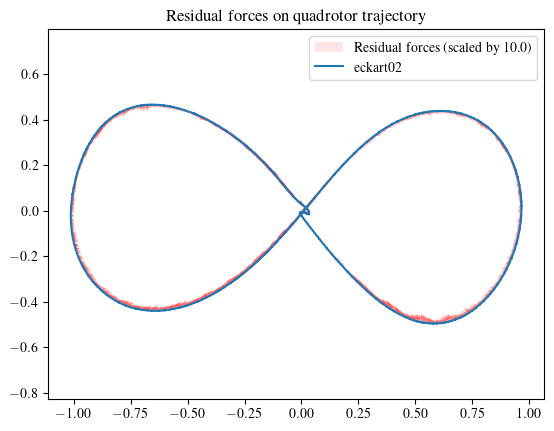

In [3]:
THREE_D = False

data_path = testing_data_paths[0]
visual_scale = 10.

if THREE_D:
    fig = plt.figure()
    ax = plt.axes(projection='3d')

data = cfusdlog.decode(data_path)['fixedFrequency']
label = os.path.basename(data_path)

x = [i for i in data["stateEstimate.x"]]
y = [i for i in data["stateEstimate.y"]]
z = [i for i in data["stateEstimate.z"]]
origin = np.array([x, y, z]).T

f, _ = residual_func(data)
vector = np.array([f[:, 0], f[:, 1], f[:, 2]]).T * visual_scale
if THREE_D:
    ax.quiver(origin[:, 0], origin[:, 1], origin[:, 2], vector[:, 0], vector[:, 1],
              vector[:, 2], color='r', alpha=.1, label=f"Residual forces (scaled by {visual_scale})")
else:
    plt.quiver(origin[:, 0], origin[:, 1], vector[:, 0], vector[:, 1], color='r',
              alpha=.1, label=f"Residual forces (scaled by {visual_scale})")

if THREE_D:
    ax.plot3D(x, y, z, label=label)
else:
    plt.plot(x, y, label=label)

# Calculate the avg. residual force for each axis
for j, v in enumerate(["x", "y", "z"]):
    f_j = [f_[j] for f_ in f]
    print(f"{label} mean residual f_{v}: {sum(f_j)/len(f_j)}")

plt.title("Residual forces on quadrotor trajectory")
plt.legend()
plt.axis('equal')
plt.show()

## Training the model

In [4]:
# Create and train neural network
model = MLP()
model.train_model(train_dataloader, test_dataloader, epochs=48)
model.show_progress()
model.save("mlp")

KeyboardInterrupt: 

## Testing the model

Average error: (x) -> 0.0004308482183636882 (y) -> 0.0007425259332305609


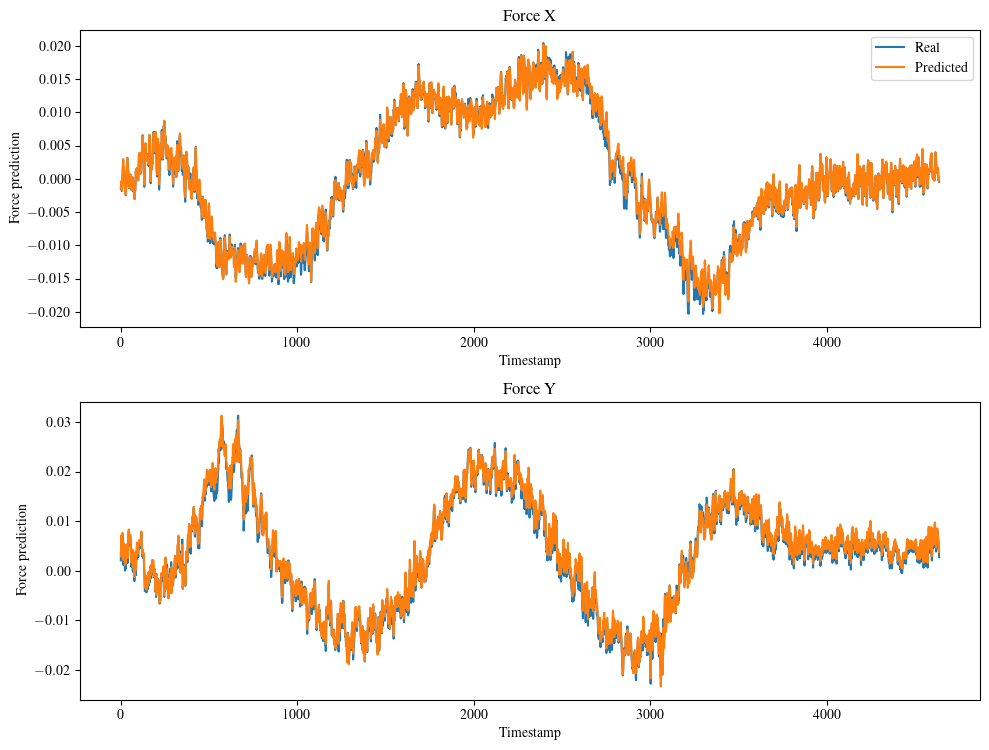

In [ ]:
weights = torch.load('./models/mlp.pth')
model.load_state_dict(weights)

tensor_input = torch.from_numpy(X_test)
pred = model.forward(tensor_input).detach().numpy()
error = np.abs(y_test-pred)
print(f"Average error: (x) -> {np.mean(error[:, 0])} (y) -> {np.mean(error[:, 1])}")

fig, ax = plt.subplots(2, figsize=(10, 8))

ax[0].plot(y_test[:, 0], label="Real")
ax[0].plot(pred[:, 0], label="Predicted")
ax[0].set_title('Force X')
ax[0].set_xlabel('Timestamp')
ax[0].set_ylabel('Force prediction')
ax[0].legend()

ax[1].plot(y_test[:, 1], label="Real")
ax[1].plot(pred[:, 1], label="Predicted")
ax[1].set_title('Force Y')
ax[1].set_xlabel('Timestamp')
ax[1].set_ylabel('Force prediction')

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("./old_scripts/imgs/nn_inf.png", dpi=600)
plt.show()

## Translating the model to c code

In [ ]:
# Generate the model c code
model_path = "./models/mlp.pth"
exportNet(model_path, info="Neural network for the standard Crazyflie")

# Test if the generated model gives the same outputs as the original
nn_c_model_test(model, "./data/test_data_payload.npz")

Comparing with original...
Models give the same outputs!


## Adding the model to the cf-firmware

In [ ]:
shutil.copyfile("./LMCE/c_utils/nn.c", "./crazyflie-firmware/src/modules/src/controller/nn.c")
shutil.copyfile("./LMCE/c_utils/nn.h", "./crazyflie-firmware/src/modules/interface/controller/nn.h")

'./crazyflie-firmware/src/modules/interface/controller/nn.h'

## Error calculation
For calculating the error with the addition of the learning models the flights need to be re-recorded with the updated firmware.

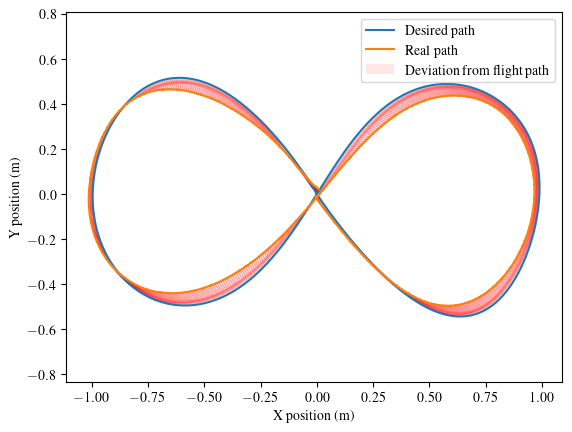

Avg. error: 0.0478 (m)


In [ ]:
# Get desired path
traj = uav_trajectory.Trajectory()
traj.loadcsv("./LMCE/flight_paths/figure8.csv")
traj.stretchtime(2)

ts = np.arange(0, traj.duration, 0.01)
evals = np.empty((len(ts), 15))
for t, i in zip(ts, range(0, len(ts))):
    e = traj.eval(t)
    e.pos += np.array([0, 0, 1])
    evals[i, 0:3] = e.pos

target_pos = evals.transpose()

# Get real path
data_path = testing_data_paths[0]
data = cfusdlog.decode(data_path)['fixedFrequency']
real_pos = [data["stateEstimate.x"], data["stateEstimate.y"]]

# Calculate error
cutoff = find_best_cutoff(real_pos, target_pos)
avg_error = error_calculator(cutoff, real_pos, target_pos, vis=True)
print(f"Avg. error: {avg_error:.4f} (m)")